In [87]:
#import fastai
from fastai import *          # Quick access to most common functionality
from fastai.vision import *   # Quick access to computer vision functionality
from fastai.callbacks import *

In [88]:
import pytorch_ssim as ssim
from superres import *
from torchvision.models import vgg16_bn
import czifile

In [89]:
path = Path('/DATA/WAMRI/salk/uri/BPHO/')
path_raw = path/'raw'
path_processed = path/'processed'
path_input = path/'input3'
path_target = path/'target3'

path_input.mkdir(exist_ok=True)
path_target.mkdir(exist_ok=True)

def to_airyscan(fn):
    new_fn = fn.stem + '_Airyscan Processing' + fn.suffix
    new_fn = Path(new_fn)
    new_parent = (path_processed/fn.relative_to(path_raw)).parent
    return new_parent/new_fn

In [90]:
raw_files = list(path_raw.glob('*'))
path_raw, len(raw_files)
fn = raw_files[0]

In [91]:
def get_czi_shape_info(czi):
    shape = czi.shape
    axes = czi.axes
    axes_dict = {axis:idx for idx,axis in enumerate(czi.axes)}
    shape_dict = {axis:shape[axes_dict[axis]] for axis in czi.axes}
    return axes_dict, shape_dict


def build_index(axes, ix_select):
    idx = [ix_select.get(ax, 0) for ax in axes]
    return tuple(idx)


def process_czi2(raw_fn):
    proc_fn = to_airyscan(raw_fn)
    if not proc_fn.exists():
        print(f'no match: {proc_fn}')
        return
    
    with czifile.CziFile(fn) as raw_czf:
        raw_axes, raw_shape = get_czi_shape_info(raw_czf)
        channels = raw_shape['C'] // 2
        sensors = raw_shape['H']
        depths = raw_shape['Z']
        x,y = raw_shape['X'], raw_shape['Y']
        data = raw_czf.asarray()
        for channel in range(channels):
            depth = depths//2
            idx = build_index(raw_axes, {'H':slice(0,3), 'C': channel, 'Z':depth,
                                         'X':slice(0,x),'Y':slice(0,y)})
            img = data[idx]
            save_raw_fn = path_input/f'{raw_fn.stem}_{channel:02d}.npy'
            np.save(save_raw_fn, img)
                    
    with czifile.CziFile(proc_fn) as proc_czf:
        proc_axes, proc_shape = get_czi_shape_info(proc_czf)
        channels = proc_shape['C']
        depths = proc_shape['Z']
        x,y = proc_shape['X'], proc_shape['Y']
        data = proc_czf.asarray()
        for channel in range(channels):
            depth = depths//2
            idx = build_index(proc_axes, {'C': channel, 'Z':depth, 'X':slice(0,x),'Y':slice(0,y)})
            img = data[idx]
            save_proc_fn = path_target/f'{raw_fn.stem}_{channel:02d}.npy'
            np.save(save_proc_fn, img)

def process_czi(raw_fn):
    proc_fn = to_airyscan(raw_fn)
    if not proc_fn.exists():
        print(f'no match: {proc_fn}')
        return
    
    with czifile.CziFile(fn) as raw_czf:
        raw_axes, raw_shape = get_czi_shape_info(raw_czf)
        channels = raw_shape['C'] // 2
        sensors = raw_shape['H']
        depths = raw_shape['Z']
        x,y = raw_shape['X'], raw_shape['Y']
        data = raw_czf.asarray()
        for channel in range(channels):
            for depth in range(depths):
                for sensor in range(sensors):
                    idx = build_index(raw_axes, {'H':sensor, 'C': channel, 'Z':depth,
                                                 'X':slice(0,x),'Y':slice(0,y)})
                    img = data[idx]
                    save_raw_fn = path_input/f'{raw_fn.stem}_{channel:02d}_{depth:03d}_{sensor:02d}.npy'
                    np.save(save_raw_fn, img)
                    
    with czifile.CziFile(proc_fn) as proc_czf:
        proc_axes, proc_shape = get_czi_shape_info(proc_czf)
        channels = proc_shape['C']
        depths = proc_shape['Z']
        x,y = proc_shape['X'], proc_shape['Y']
        data = proc_czf.asarray()
        for channel in range(channels):
            for depth in range(depths):
                idx = build_index(proc_axes, {'C': channel, 'Z':depth, 'X':slice(0,x),'Y':slice(0,y)})
                img = data[idx]
                save_proc_fn = path_target/f'{raw_fn.stem}_{channel:02d}_{depth:03d}.npy'
                np.save(save_proc_fn, img)
        

In [6]:
# for fn in progress_bar(raw_files):
#    process_czi2(fn)

In [7]:
class RawImage3List(ImageImageList):
    def open(self, fn):
        data = np.load(fn)
        x = torch.from_numpy(data.astype(np.float32))
        x.div_(255)
        return Image(x)


class RawImageList(ImageImageList):
    def open(self, fn):
        data = np.load(fn)
        x = torch.from_numpy(data[None,:,:].astype(np.float32))
        x.div_(255)
        return Image(x)
    
class ProcImageList(ImageImageList):
    def open(self, fn):
        data = np.load(fn)
        x = torch.from_numpy(data[None,:,:].astype(np.float32))
        x.div_(8000)
        return Image(x)

In [57]:
def get_basename(x):
    return x.stem.split('_')[0]

base_names = list(set([get_basename(x) for x in list(path_input.iterdir())]))
train_names, valid_names = random_split(0.15, base_names)
valid_names = list(valid_names[0])

def is_validation_basename(x):
    xbase = get_basename(x)
    return xbase in valid_names

src = (RawImage3List
       .from_folder(path_input, label_cls=ProcImageList, extensions=".npy")
       .split_by_valid_func(is_validation_basename))

def get_data(src,bs,size, **kwargs):
#     def raw_to_processed_fn(x):
#         x_proc = path_target/str(x.stem[:-3] + ".png.npy")
#         return x_proc
    def raw_to_processed_fn(x):
        x_proc = path_target/str(x.stem + ".npy")
        return x_proc
    
    data = (src.label_from_func(raw_to_processed_fn)
            .transform(get_transforms(), size=size, tfm_y=True)
            .databunch(bs=bs,**kwargs))
    data.c = 3
    return data

In [58]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [59]:
def mult_loss(input, target):
    return 1000. * F.mse_loss(input, target)

loss = mult_loss
size = 256
bs = 8
data = get_data(src, bs, size)

In [11]:
data.train_ds[0][0].data.std()

tensor(0.0029)

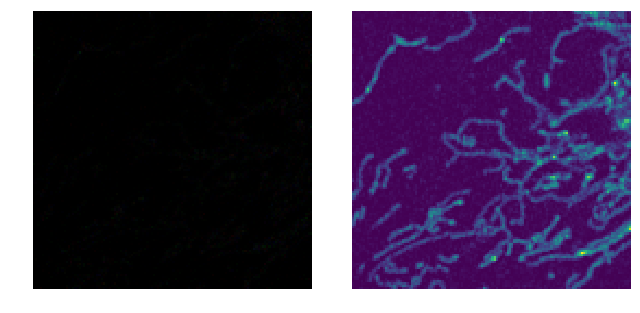

In [12]:
data.show_batch(ds_type=DatasetType.Valid, rows=1, figsize=(9,9))

In [61]:
scale=1
n_resblocks=16
n_feats=128
res_scale= 0.1
model = WDSR(scale, n_resblocks, n_feats, res_scale, n_colors_in=3, n_colors_out=1)
model = nn.DataParallel(model) #.eval().cuda()

In [64]:
learn = Learner(data, model, loss_func=loss, metrics=superres_metrics)
learn=learn.load('test')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


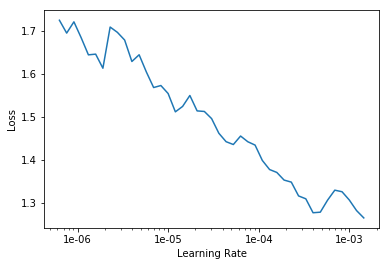

In [15]:
learn.lr_find()
learn.recorder.plot()

In [82]:
lr = 1e-4
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,mse_loss,edge_loss,ssim,psnr
1,0.366193,0.222644,0.000223,0.004911,0.831299,36.600628
2,0.353568,0.217729,0.000218,0.004786,0.831580,36.700859
3,0.346958,0.211408,0.000211,0.004550,0.819487,36.830883
4,0.332694,0.204596,0.000205,0.004302,0.804911,36.966003
5,0.311070,0.195606,0.000196,0.004148,0.828462,37.167515
6,0.305414,0.188937,0.000189,0.004024,0.850972,37.325409
7,0.308529,0.188853,0.000189,0.003925,0.834312,37.323475
8,0.307138,0.184246,0.000184,0.003875,0.853105,37.436436
9,0.299504,0.186508,0.000187,0.003847,0.835446,37.378735
10,0.296550,0.185748,0.000186,0.003844,0.839313,37.397453


In [83]:
v = learn.pred_batch(DatasetType.Valid)

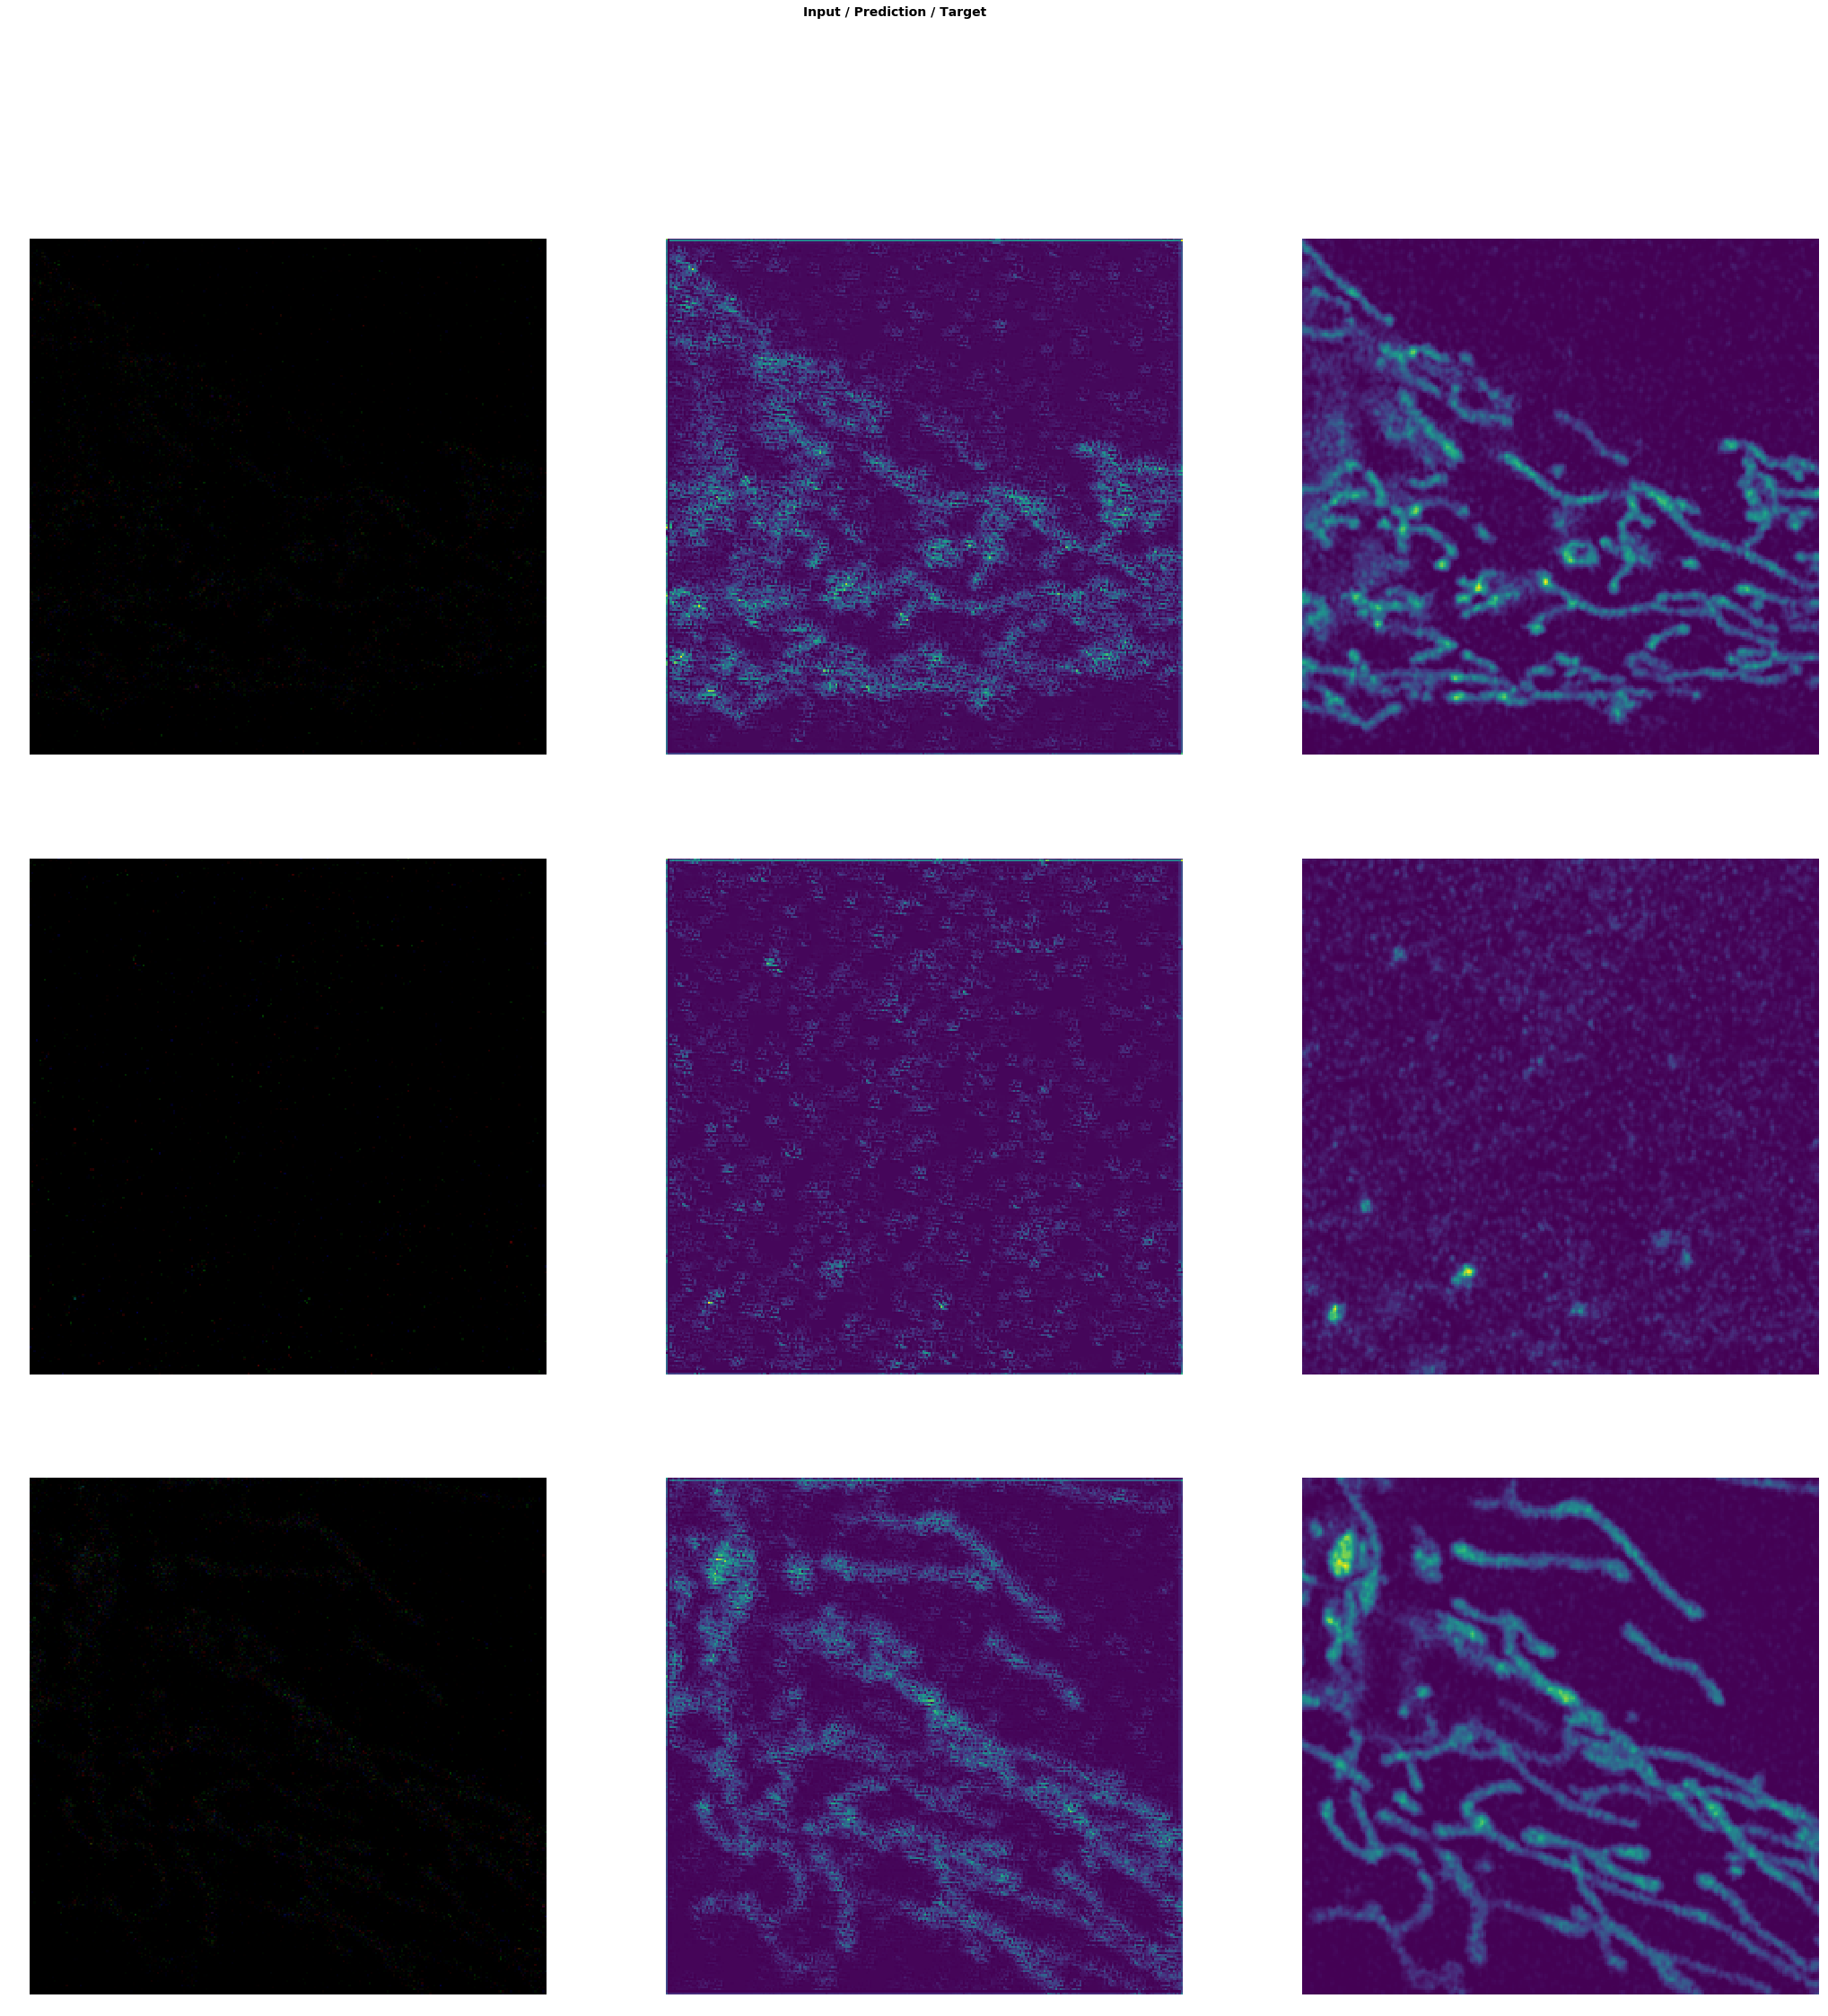

In [84]:
learn.show_results(rows=3, imgsize=12)

In [85]:
learn.save('test')

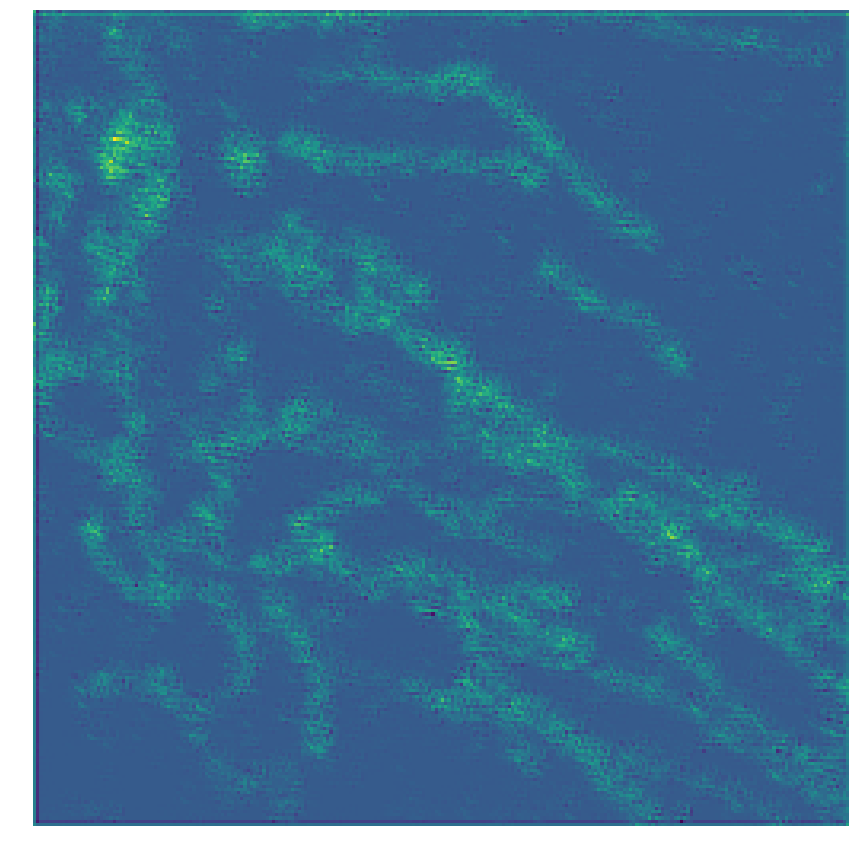

In [86]:
img = Image(v[2])
img.show(figsize=(15,15))